<a href="https://colab.research.google.com/github/wzuidema/cascaded_disentanglement/blob/main/disentanglement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook aims to provide a minimal viable execution of the cascaded disentanglement approach described in the paper [Posthoc Disentanglement of Textual and Acoustic Features in Self-Supervised Speech Encoders](https://github.com/wzuidema/cascaded_disentanglement/blob/main/Speech_Disentanglement.pdf), by Hosein Mohebbi, Afra Alishahi, Grzegorz Chrupała, Willem Zuidema and Ivan Titov.



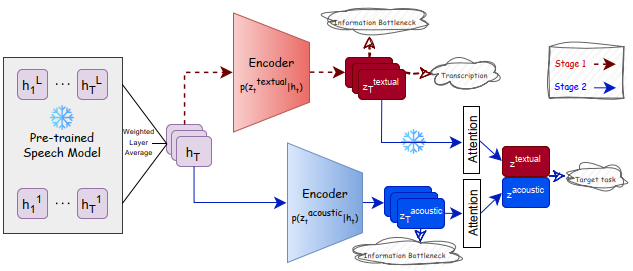

# 1. Preliminaries (global variables, installs, imports)

In [ ]:
#@title Global variables
STAGE = "2"
DATA_S1 = "CommonVoice_LibriSpeech" #check
DATA_S2 = "RAVDESS"     # IEMOCAP, ...
LATENT_DIM = 128        # encoder bottleneck dimension e.g., "128"
MODEL_NAME = "wav2vec2-base" # an exising speech model
## mappings available for: {'wav2vec2-base': 'facebook/wav2vec2-base-960h', 'wav2vec2-base-960h': 'facebook/wav2vec2-base-960h',
#'hubert-base-ls960': 'facebook/hubert-large-ls960-ft', 'wav2vec2-large': 'facebook/wav2vec2-large-960h',
#'wav2vec2-large-960h': 'facebook/wav2vec2-large-960h', 'hubert-large-ll60k': 'facebook/hubert-large-ls960-ft',
#'hubert-large-ls960-ft': 'facebook/hubert-large-ls960-ft'}

LAYER_S1 = "all"        # "all" for layer averaging, otherwise specify the model layer number
LAYER_S2 = "all"        # "all" for layer averaging, otherwise specify the model layer number
LEARNING_RATE = 0.001   # note: needs to correspond with existing checkpoints if youn want to use them
BETA_S1 = "incremental" # "incremental" or a constant coefficient
BETA_S2 = "incremental" # "incremental" or a constant coefficient if you set stage to "2"
NO_IB = False #args.NO_IB #check
SEED = 7

DATA = DATA_S1 if STAGE == "1" else DATA_S2
#OBJECTIVE = "emotion" if DATA_S2 == "IEMOCAP" else "speaker_id"
OBJECTIVE = "emotion" if DATA_S2 == "RAVDESS" else "speaker_id"
OBJECTIVE2 = "mean_pitch" # trying to keep track of a second feature for visualization
## assuming the code Hosein provided for ravdess is in fact also fine
BATCH_SIZE = 1 if STAGE == "1" else 8
LAYER_S1 = LAYER_S1 if LAYER_S1 == "all" else int(LAYER_S1)
LAYER_S2 = LAYER_S2 if LAYER_S2 in ["all", None] else int(LAYER_S2)
LEARNING_RATE = float(LEARNING_RATE)
SEED = int(SEED)
BETA = BETA_S1 if STAGE == "1" else BETA_S2

EPOCHS = 10 # Hosein's default is 50; but on RAVDESS/emotions convergence at 20
EVAL_FREQ = 5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.005
MAX_GRAD_NORM = 1
SELECTED_GPU = 0
DATA_ = DATA_S1 if STAGE == "1" else DATA_S1 + "_" + DATA_S2

DATA_PATH = f"/content/disentangling_representations/directory/data/"
LOAD_STAGE1_PATH = f"/content/disentangling_representations/directory/models/vib/1/{DATA_S1}/{MODEL_NAME}/"
SAVE_REPORTS_PATH = f"/content/disentangling_representations/directory/reports/vib/{STAGE}/{DATA_}/{MODEL_NAME}/"
SAVE_MODEL_PATH = f"/content/disentangling_representations/directory/models/vib/{STAGE}/{DATA_}/{MODEL_NAME}/"

print(STAGE)
print(MODEL_NAME)
print(DATA)

2
wav2vec2-base
RAVDESS


In [ ]:
#@title Installs
#!pip install fsspec==2025.3.2
!pip install datasets
!pip install evaluate
!pip install praat-parselmouth

In [ ]:
!pip install fsspec==2023.9.2

In [ ]:
#@title Imports
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import uuid
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from datasets import concatenate_datasets, load_from_disk, Audio
from evaluate import load
from transformers import Wav2Vec2Processor, Wav2Vec2Model, HubertModel
from transformers import get_cosine_schedule_with_warmup
#from vib import VIB, VIBConfig
#from utils import MODEL_NAME_MAPPER, PROCESSOR_MAPPER, NUM_CLASSES_MAPPER, METRIC_MAPPER

## GPU
if torch.cuda.is_available():
    device = torch.device(f"cuda:{SELECTED_GPU}")
    print('We will use the GPU:', torch.cuda.get_device_name(SELECTED_GPU))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')


We will use the GPU: Tesla T4


# 2. Download the Cascaded Disentanglement code

In [ ]:
! git clone https://github.com/hmohebbi/disentangling_representations.git

Cloning into 'disentangling_representations'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 139 (delta 20), reused 23 (delta 9), pack-reused 101 (from 2)
Receiving objects: 100% (139/139), 275.58 MiB | 13.79 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (57/57), done.


In [ ]:
import sys
sys.path.append("/content/disentangling_representations/")

if not os.path.exists(SAVE_REPORTS_PATH):
    os.makedirs(SAVE_REPORTS_PATH)
if not os.path.exists(SAVE_MODEL_PATH):
    os.makedirs(SAVE_MODEL_PATH)

# 3. Create data set

###Loading packages to load and process datasets

In [ ]:
SAVE_DATA_PATH = f"/content/disentangling_representations/directory/data/"
SEED = 42
MAX_SECOND = 14.0

import re
import parselmouth
from parselmouth.praat import call
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from datasets import Audio, Value, ClassLabel, DatasetDict, Dataset
from datasets import load_dataset, concatenate_datasets
import pandas as pd
from sklearn.model_selection import train_test_split
import json

if not os.path.exists(SAVE_DATA_PATH):
    os.makedirs(SAVE_DATA_PATH)


### Data preparation functions

In [ ]:
def balance(data, key):
    unique_labels, label_counts = np.unique(data[key], return_counts=True)
    min_count = label_counts.min()
    balanced_datasets = []
    for l in unique_labels:
        selected_indices = np.where(np.array(data[key]) == l)[0]
        np.random.shuffle(selected_indices)
        one_class_data = data.select(selected_indices[:min_count])
        balanced_datasets.append(one_class_data)
    balanced_data = concatenate_datasets(balanced_datasets, axis=0).shuffle(seed=SEED)
    return balanced_data

def add_extracted_audio_features(data):
    features = {'duration': [],
                'mean_intensity': [],
                'mean_pitch': [],
                'std_pitch': [],
                'local_jitter': [],
                'local_shimmer': [],
                }

    for ex in range(len(data)):
        duration = len(data[ex]['audio']['array']) / data[ex]['audio']['sampling_rate']
        sound = parselmouth.Sound(data[ex]['audio']['array'], data[ex]['audio']['sampling_rate'])
        unit = "Hertz"
        f0min, f0max = 75, 600 # Hz
        pitch = sound.to_pitch()
        # times = pitch.xs()
        mean_pitch = call(pitch, "Get mean", 0, 0, unit)
        std_pitch = call(pitch, "Get standard deviation", 0 ,0, unit)
        pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
        local_jitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
        local_shimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
        mean_intensity = sound.get_intensity()

        if pd.isna(mean_pitch):
            mean_pitch = 0
        if pd.isna(std_pitch):
            std_pitch = 0
        if pd.isna(local_jitter):
            local_jitter = 0
        if pd.isna(local_shimmer):
            local_shimmer = 0

        features['duration'].append(duration)
        features['mean_intensity'].append(mean_intensity)
        features['mean_pitch'].append(mean_pitch)
        features['std_pitch'].append(std_pitch)
        features['local_jitter'].append(local_jitter)
        features['local_shimmer'].append(local_shimmer)


    data = data.add_column('duration', features['duration'])
    data = data.add_column('mean_intensity', features['mean_intensity'])
    data = data.add_column('mean_pitch', features['mean_pitch'])
    data = data.add_column('std_pitch', features['std_pitch'])
    data = data.add_column('local_jitter', features['local_jitter'])
    data = data.add_column('local_shimmer', features['local_shimmer'])

    return data


### A note on ravdess
The following code will download the 'ravdess' dataset from the HuggingFace hub. I chose ravdess because it's small, easy to download and Hosein's code included some code snippets for me to work with. However, the dataset is probably too small to learn good representations of the 4 emotions (and the following code doesn't yet split the dataset in a train and test split). In the paper, Hosein opted to train and evaluate on IEMOCAP instead (this dataset is now also in my google drive: https://drive.google.com/file/d/1A9VJ-t-DgsSCLAHxFBDQCJH9fABktvnL/view?usp=drive_link).

### Loading and processing ravdess

In [ ]:
# load RAVDESS
ravdess = DatasetDict()
ravdess['train'], ravdess['test'] = load_dataset("narad/ravdess", split=['train','train']) # turns out RAVDESS doesn't have a test split...

def labeling(example):
    if example["emotion"] == 0:
        example["emotion"] = 2
    elif example["emotion"] == 2:
        example["emotion"] = 1
    elif example["emotion"] == 3:
        example["emotion"] = 3
    elif example["emotion"] == 4:
        example["emotion"] = 0
    else:
        print("Wrong emotion label!")
        return None
    return example

for tt in ['train', 'test']:
    ravdess[tt] = ravdess[tt].rename_column("text", "transcription")
    ravdess[tt] = ravdess[tt].rename_column("labels", "emotion")
    ravdess[tt] = ravdess[tt].rename_column("speaker_id", "speaker_ids")
    ravdess[tt] = ravdess[tt].rename_column("speaker_gender", "gender")
    # keep only 4 classes: ang, hap, neu, sad
    ravdess[tt] = ravdess[tt].filter(lambda example: example['emotion'] in [0, 2, 3, 4])
    ravdess[tt] = ravdess[tt].map(labeling)

    # filtering out long audios (> MAX_SECOND)
    ravdess[tt] = ravdess[tt].filter(lambda example: len(example['audio']['array'])/example['audio']['sampling_rate'] <= MAX_SECOND)

    # make transcriptions uppercase
    ravdess[tt] = ravdess[tt].map(lambda example: {'transcription': example["transcription"].strip().upper()})

    # casting
    ravdess[tt] = ravdess[tt].cast_column("emotion", ClassLabel(num_classes=4, names=['ang', 'hap', 'neu', 'sad']))
    ravdess[tt] = ravdess[tt].cast_column("audio", Audio(sampling_rate=16000))

    # gender and speaker id
    ravdess[tt] = ravdess[tt].map(lambda example: {"gender": 0 if example["gender"] == "female" else 1})
    speaker_ids, _ = pd.factorize(ravdess[tt]['speaker_ids'])
    ravdess[tt] = ravdess[tt].add_column("speaker_id", speaker_ids)
    ravdess[tt] = ravdess[tt].remove_columns("speaker_ids")
    ravdess[tt] = ravdess[tt].shuffle(seed=SEED)

    # balancing emotion class with downsampling
    ravdess[tt] = balance(ravdess[tt], key='emotion')

#ravdess_dataset = DatasetDict()
#ravdess_dataset['train'] = ravdess['train']
#ravdess_dataset['test'] = ravdess['test']

# Extract audio features of RAVDESS
ravdess['train'] = add_extracted_audio_features(ravdess['train'])
ravdess['test'] = add_extracted_audio_features(ravdess['test'])

# save
ravdess.save_to_disk(f"{SAVE_DATA_PATH}RAVDESS")

<ipython-input-13-2c194b242491>:40: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  speaker_ids, _ = pd.factorize(ravdess[tt]['speaker_ids'])
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Flattening the indices:   0%|          | 0/384 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/384 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/384 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/384 [00:00<?, ? examples/s]

# 4. Load model definitions and helper functions from the disentanglement package

In [ ]:
sys.path.append("/content/disentangling_representations/vib/")

In [ ]:
#@title %load disentangling_representations/utils.py
import sys, os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

MODEL_NAME_MAPPER = {
    'wav2vec2-base': "facebook/wav2vec2-base", # pre-trained
    'wav2vec2-base-960h': "facebook/wav2vec2-base-960h", # fine-tuned
    'hubert-base-ls960': "facebook/hubert-base-ls960", # pre-trained
    'wav2vec2-large': "facebook/wav2vec2-large", # pre-trained
    'wav2vec2-large-960h': "facebook/wav2vec2-large-960h", # fine-tuned
    'hubert-large-ll60k': "facebook/hubert-large-ll60k", # pre-trained
    'hubert-large-ls960-ft': "facebook/hubert-large-ls960-ft", # fine-tuned
}
PROCESSOR_MAPPER = { # use tokenizers of finetuned models
    'wav2vec2-base': "facebook/wav2vec2-base-960h",
    'wav2vec2-base-960h': "facebook/wav2vec2-base-960h",
    'hubert-base-ls960': "facebook/hubert-large-ls960-ft",
    'wav2vec2-large': "facebook/wav2vec2-large-960h",
    'wav2vec2-large-960h': "facebook/wav2vec2-large-960h",
    'hubert-large-ll60k': "facebook/hubert-large-ls960-ft",
    'hubert-large-ls960-ft': "facebook/hubert-large-ls960-ft",
}

EMOTION_LABEL_MAPPER = {
    '0': 'ang',
    '1': 'hap',
    '2': 'neu',
    '3': 'sad',
}

GENDER_LABEL_MAPPER = {
    '0': 'female',
    '1': 'male',
}

METRIC_MAPPER = {
    'ctc': 'wer',
    'emotion': 'accuracy',
    '1': 'wer',
    '2': 'accuracy',
    'duration': 'accuracy',
    'mean_intensity': 'accuracy',
    'mean_pitch': 'accuracy',
    'std_pitch': 'accuracy',
    'local_jitter': 'accuracy',
    'local_shimmer': 'accuracy',
    'gender': 'accuracy',
    'speaker_id': 'accuracy',
}

NUM_CLASSES_MAPPER = {
    'ctc': 32,
    'emotion': 4,
    '1': 32,
    '2': 4,
    'duration': 4,
    'mean_intensity': 4,
    'mean_pitch': 4,
    'std_pitch': 4,
    'local_jitter': 4,
    'local_shimmer': 4,
    'gender': 2,
    'speaker_id': 24,
}


def normalize(train_data, test_data, key):
    # fit for train
    normalizer = MinMaxScaler().fit(np.array(train_data[key]).reshape(-1, 1))
    # transform train
    normalized_values = normalizer.transform(np.array(train_data[key]).reshape(-1, 1)).flatten().tolist()
    train_data = train_data.remove_columns(key)
    train_data = train_data.add_column(key, normalized_values)
    # transform test
    normalized_values = normalizer.transform(np.array(test_data[key]).reshape(-1, 1)).flatten().tolist()
    test_data = test_data.remove_columns(key)
    test_data = test_data.add_column(key, normalized_values)
    return train_data, test_data


def discretize(train_data, test_data, key):
    # train data
    discretized_train_values, bin_edges = pd.qcut(pd.Series(train_data[key]), 4, labels=[0, 1, 2, 3], retbins=True)
    discretized_train_values = discretized_train_values.to_numpy().astype(int)
    train_data = train_data.remove_columns(key)
    train_data = train_data.add_column(key, discretized_train_values)

    # discretize the test data according to bins in train data
    discretized_test_values = pd.cut(pd.Series(test_data[key]), bins=bin_edges, labels=[0, 1, 2, 3], include_lowest=True)
    discretized_test_values = discretized_test_values.to_numpy().astype(int)
    test_data = test_data.remove_columns(key)
    test_data = test_data.add_column(key, discretized_test_values)

    return train_data, test_data


def get_frame_boundaries(start, end, total_frames, total_audio_time):
    start = total_frames * start / total_audio_time
    end = total_frames * end / total_audio_time
    start = np.ceil(start).astype('int')
    end = np.ceil(end).astype('int')
    return start, end


def add_mfa(dataset, alignment_path, split):
    alignments = []
    alignment_path = f"{alignment_path}{split}/outputs/"
    file_ids = [int(f.split('.')[0]) for f in os.listdir(alignment_path) if f.endswith('.TextGrid')]
    file_ids = np.sort(file_ids)
    for ex in range(dataset.num_rows):
        if ex not in file_ids:
            alignments.append(None)
            continue
        lines = open(f"{alignment_path}{ex}.TextGrid", "r").readlines()
        num_intervals = int(lines[13].strip().split('=')[-1])
        mfa_intervals = []
        for it in range(num_intervals):
            xmin = float(lines[15+it*4].split("=")[-1].strip())
            xmax = float(lines[16+it*4].split("=")[-1].strip())
            text = lines[17+it*4].split("=")[-1].strip()[1:-1]
            if text != "":
                mfa_intervals.append({'start': xmin, 'end': xmax, 'word': text})
        alignments.append(mfa_intervals)
    # add mfa info to the dataset
    dataset = dataset.add_column("mfa_intervals", alignments)
    # filter examples with unsuccessfull mfa
    dataset = dataset.select(file_ids)
    return dataset

In [ ]:
#@title %load disentangling_representations/vib/vib.py
import torch
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Optional

def unweighted_average(x, m):
    m = m.unsqueeze(-1).expand_as(x)
    effective_x = x * m
    sum_effective_x = torch.sum(effective_x, dim=1)
    pooled_x = sum_effective_x / torch.sum(m, dim=1)
    return pooled_x

class SelfAttention(torch.nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.query = torch.nn.Parameter(torch.ones(1, embed_dim), requires_grad=True)

    def forward(self, x, attention_mask=None, output_attentions=False):
        """Input shape: Batch x Time x Hidden Dim"""

        scores = torch.matmul(x, self.query.unsqueeze(0).transpose(-2, -1)).squeeze(-1)  # (batch_size, seq_len)
        if attention_mask is not None:
            scores = scores.masked_fill(attention_mask == False, float('-inf'))

        attn_weights = torch.nn.functional.softmax(scores, dim=-1).unsqueeze(-1)

        # weighted average
        pooled_x = torch.sum(attn_weights * x, dim=1)

        outputs = (pooled_x, attn_weights) if output_attentions else (pooled_x,)
        return outputs


@dataclass
class VIBConfig():
    input_dim: Optional[int] = None
    latent_dim: Optional[int] = None
    num_classes: Optional[int] = None
    stage: Optional[str] = None
    layer_weight_averaging: Optional[bool] = False
    num_layers: Optional[int] = None

class VariationalEncoder(torch.nn.Module):
    def __init__(self, config):
        super(VariationalEncoder, self).__init__()
        self.enc1 = torch.nn.Linear(config.input_dim, config.input_dim)
        self.enc2 = torch.nn.Linear(config.input_dim, config.input_dim)
        self.mu = torch.nn.Linear(config.input_dim, config.latent_dim)
        self.var = torch.nn.Linear(config.input_dim, config.latent_dim)

    def forward(self, h):
        o = F.gelu(self.enc1(h))
        o = F.gelu(self.enc2(o))

        mu = self.mu(o)
        var = F.softplus(self.var(o)) # to generate positive values

        return mu, var

class FrameDecoder(torch.nn.Module):
    def __init__(self, config):
        super(FrameDecoder, self).__init__()
        self.lm_head = torch.nn.Linear(config.latent_dim, config.num_classes)

    def forward(self, z, m=None, cond=None, output_attentions=False):
        logits = self.lm_head(z)
        return (logits,)

class UtteranceDecoder(torch.nn.Module):
    def __init__(self, config):
        super(UtteranceDecoder, self).__init__()
        self.cond_attention = SelfAttention(config.latent_dim)
        self.z_attention = SelfAttention(config.latent_dim)
        self.clf = torch.nn.Linear(config.latent_dim*2, config.num_classes) # latent_dim * 2 due to concatenation

    def forward(self, z, m, cond, output_attentions=False):
        # pooled_cond = unweighted_average(cond, m)
        # pooled_z = unweighted_average(z, m)
        attn_out_cond = self.cond_attention(cond, m, output_attentions=output_attentions)
        attn_out_z = self.z_attention(z, m, output_attentions=output_attentions)
        pooled_cond, pooled_z = attn_out_cond[0], attn_out_z[0]
        concatenated_pooled = torch.concat([pooled_cond, pooled_z], dim=-1)

        logits = self.clf(concatenated_pooled)

        outputs = (logits, attn_out_cond[1], attn_out_z[1]) if output_attentions else (logits,)
        return outputs

class VIB(torch.nn.Module):
    def __init__(self, config):
        super(VIB, self).__init__()
        self.layer_weight_averaging = config.layer_weight_averaging
        if self.layer_weight_averaging:
            self.layer_weights = torch.nn.Parameter(torch.ones(config.num_layers)/config.num_layers, requires_grad=True)

        self.encoder = VariationalEncoder(config)

        if config.stage == "1":
            self.decoder = FrameDecoder(config)
        elif config.stage == "2":
            self.decoder = UtteranceDecoder(config)
        else:
            raise ValueError("Invalid VIB training stage!")

    def forward(self, h, m=None, cond=None, output_attentions=False, noise=True):
        if self.layer_weight_averaging:
            # compute weighted sum over layers
            w = torch.nn.functional.softmax(self.layer_weights, dim=0)
            h = torch.sum(h * w.view(1, w.shape[0], 1, 1), dim=1)

        mu, var = self.encoder(h)
        std = var ** 0.5
        # # reparameterization trick: introducing epsilon only during training, and use the z = mu during inference
        if self.training and noise:
            eps = torch.randn_like(std) # sample from N(0, 1)
            z = mu + std * eps
        else:
            z = mu

        # decoing
        outputs = self.decoder(z, m, cond, output_attentions)

        return outputs + (mu, var)


In [ ]:
#@title Relevant helper functions from training.py
def load_list_of_data(data, split):
    data_list = [load_from_disk(f"{DATA_PATH}{d}")[split].select_columns(['audio', 'transcription'] if STAGE == "1" else ['audio', OBJECTIVE, 'mean_pitch']).cast_column("audio", Audio(sampling_rate=16000)) for d in data]
    return concatenate_datasets(data_list, axis=0)

def prepare_dataset(batch):
    batch['input_values'] = processor(batch["audio"]["array"], sampling_rate=batch['audio']['sampling_rate']).input_values[0]
    if STAGE == "1":
        with processor.as_target_processor():
            batch['labels'] = processor(batch["transcription"]).input_ids
    else:
        batch['labels'] = batch.pop(OBJECTIVE)
        batch['mean_pitch'] = batch.pop('mean_pitch')
##        jz: for visualizing the results, I want to have available not just the 'emotion' labels from the dataset,
##        but also things like 'mean_pitch' which we have added to the ravdess dataset on disk
    return batch

def collate_fn(batch):
    input_values = [{"input_values": x["input_values"]} for x in batch]
    features = processor.pad(input_values, padding=True, return_attention_mask=True, return_tensors="pt")
    if STAGE == "1": # transcription labels
        labels = [{"input_ids": x["labels"]} for x in batch]
        with processor.as_target_processor():
            labels = processor.pad(labels, padding=True, return_tensors="pt")
        # replacing padding with -100 to ignore loss correctly
        features["labels"] = labels['input_ids'].masked_fill(labels.attention_mask.ne(1), -100)
    else: # emotion/speaker id labels
        labels = [x["labels"] for x in batch]
        mean_pitches = [x["mean_pitch"] for x in batch]
        features["labels"] = torch.tensor(labels)
        features["mean_pitch"] = torch.tensor(mean_pitches)
    return features


# 5. Load pretrained models, data and run training

In [ ]:
#@title Load pretrained model (and, when in stage 2, a trained stage 1 model)

# Load pre-trained model
processor = Wav2Vec2Processor.from_pretrained(PROCESSOR_MAPPER[MODEL_NAME])
base_model = Wav2Vec2Model.from_pretrained(MODEL_NAME_MAPPER[MODEL_NAME]) if "wav2vec2" in MODEL_NAME else HubertModel.from_pretrained(MODEL_NAME_MAPPER[MODEL_NAME])
base_model.to(device)
base_model.eval()

# Load trained stage 1 vib model
if STAGE == "2":
    stage1_config = VIBConfig(
        input_dim=base_model.config.output_hidden_size if "wav2vec2" in MODEL_NAME else base_model.config.hidden_size,
        latent_dim=LATENT_DIM,
        stage="1",
        num_classes=NUM_CLASSES_MAPPER["1"],
        layer_weight_averaging=LAYER_S1 == "all",
        num_layers=base_model.config.num_hidden_layers if LAYER_S1 == "all" else None
        )
    stage1_vib = VIB(stage1_config)
    postfix = f"_bs=1_lr={LEARNING_RATE}_dim={LATENT_DIM}"
    if NO_IB:
        postfix += "_noib"
    else:
        postfix += f"_b={BETA_S1}"
    postfix += f"_layer={LAYER_S1}"
    stage1_vib.load_state_dict(torch.load(f'{LOAD_STAGE1_PATH}model{postfix}.pth', map_location=torch.device(device)))
    stage1_vib.to(device)
    stage1_vib.eval()

# Load trainable clfs
layer_weight_averaging = (STAGE == "1" and LAYER_S1 == "all") or (STAGE == "2" and LAYER_S2 == "all")
vib_config = VIBConfig(
    input_dim=base_model.config.output_hidden_size if "wav2vec2" in MODEL_NAME else base_model.config.hidden_size,
    latent_dim=LATENT_DIM,
    stage=STAGE,
    num_classes=NUM_CLASSES_MAPPER["speaker_id"] if OBJECTIVE == "speaker_id" and STAGE == "2" else NUM_CLASSES_MAPPER[STAGE],
    layer_weight_averaging=layer_weight_averaging,
    num_layers=base_model.config.num_hidden_layers if layer_weight_averaging else None
    )
model = VIB(vib_config)
model.to(device)
model.train()




preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

VIB(
  (encoder): VariationalEncoder(
    (enc1): Linear(in_features=768, out_features=768, bias=True)
    (enc2): Linear(in_features=768, out_features=768, bias=True)
    (mu): Linear(in_features=768, out_features=128, bias=True)
    (var): Linear(in_features=768, out_features=128, bias=True)
  )
  (decoder): UtteranceDecoder(
    (cond_attention): SelfAttention()
    (z_attention): SelfAttention()
    (clf): Linear(in_features=256, out_features=4, bias=True)
  )
)

## Load data for training

Note: Because for RAVDESS we only have saved one data split, we (for illustration only) train here on the same set as we test on!

In [ ]:
# Load data
train_data = load_list_of_data(data=DATA.split("_"), split='train').shuffle(seed=SEED)
test_data = load_list_of_data(data=DATA.split("_"), split='test')

train_data = train_data.map(prepare_dataset, keep_in_memory=True)
test_data = test_data.map(prepare_dataset, keep_in_memory=True)
train_data = train_data.remove_columns('audio')
test_data = test_data.remove_columns('audio')

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False, pin_memory=True, num_workers=4)

training_steps = len(train_dataloader)
total_training_steps = EPOCHS * training_steps

# Load metrics & optimizer
metric = load(METRIC_MAPPER[STAGE], experiment_id=str(uuid.uuid4()))
if STAGE == "1":
    metric_2 = load('cer', experiment_id=str(uuid.uuid4()))
optimizer = AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=np.ceil(WARMUP_RATIO * total_training_steps),
                                            num_training_steps=total_training_steps)

beta_reach_steps = (EPOCHS - 5) * training_steps
beta = 0.1 if BETA == "incremental" else float(BETA)
BETA_INCREMENT = (1.0 - beta) / beta_reach_steps if BETA == "incremental" else 0


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Train the model (note: this might take quite long)

In [ ]:
# Run
train_losses = {'Task': [], 'Info': [], 'Total': []}
test_performances = []
if STAGE == "1":
    test_performances_2 = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Feature extraction (from pre-trained speech model)
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            # attention_mask shouln't be passed to wave2vec 2.0 model
            outputs = base_model(batch["input_values"],
                                 output_hidden_states=True,
                                 return_dict=True
                                )

        hidden_states = torch.stack(outputs.hidden_states)
        frame_mask = base_model._get_feature_vector_attention_mask(hidden_states.shape[2], batch["attention_mask"])

        # Forward VIB model
        if STAGE == "1":
            logits, mu, var = model(hidden_states[1:].permute(1, 0, 2, 3) if LAYER_S1 == "all" else hidden_states[LAYER_S1].permute(1, 0, 2, 3), m=None, noise=not NO_IB)
        else: # Stage 2
            with torch.no_grad():
                _, cond, _  = stage1_vib(hidden_states[1:].permute(1, 0, 2, 3) if LAYER_S1 == "all" else hidden_states[LAYER_S1].permute(1, 0, 2, 3), m=None, noise=not NO_IB)
            outputs = model(hidden_states[1:].permute(1, 0, 2, 3) if LAYER_S2 == "all" else hidden_states[LAYER_S2].permute(1, 0, 2, 3), m=frame_mask, cond=cond, output_attentions=True, noise=not NO_IB)
            logits, cond_frame_attn, z_frame_attn, mu, var = outputs


        # Info loss
        if NO_IB:
            info_loss = 0.0
        else:
            info_loss = -0.5 * torch.sum(1 + torch.log(var) - mu.pow(2) - var, dim=-1)
            info_loss = torch.masked_select(info_loss, frame_mask).mean() # ignore padded time steps

        # Task loss
        if STAGE == "1":
            # CTC loss
            tr_labels_mask = batch['labels'] >= 0
            input_lengths = frame_mask.sum(-1)
            target_lengths = tr_labels_mask.sum(-1)
            flattened_targets = batch['labels'].masked_select(tr_labels_mask)
            if flattened_targets.max() >= base_model.config.vocab_size:
                raise ValueError("Label values must be <= vocab_size")

            log_probs = torch.nn.functional.log_softmax(logits, dim=-1).transpose(0, 1)
            with torch.backends.cudnn.flags(enabled=False):
                task_loss = torch.nn.functional.ctc_loss(log_probs,
                                                    flattened_targets,
                                                    input_lengths,
                                                    target_lengths,
                                                    blank=processor.tokenizer.pad_token_id, # 0
                                                    reduction='mean',
                                                    zero_infinity=False
                                                    )
        else: # Stage 2
            # cross entropy for emotion/speaker id loss
            task_loss = torch.nn.functional.cross_entropy(logits, batch['labels'], ignore_index=-100)

        # Total loss
        total_loss = task_loss + beta * info_loss

        # perform optimization
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # store records
        train_losses['Task'].append(task_loss.item())
        if not NO_IB:
            train_losses['Info'].append(info_loss.item())
            train_losses['Total'].append(total_loss.item())
        if BETA == "incremental":
            beta = min(beta + BETA_INCREMENT, 1.0)


    # Evaluating on test set
    if (epoch + 1) % EVAL_FREQ == 0:
        model.eval()
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                # attention_mask shouln't be passed to wave2vec 2.0 model
                outputs = base_model(batch["input_values"],
                                    output_hidden_states=True,
                                    return_dict=True
                                    )
            hidden_states = torch.stack(outputs.hidden_states)
            frame_mask = base_model._get_feature_vector_attention_mask(hidden_states.shape[2], batch["attention_mask"])

            # Forward VIB model
            if STAGE == "1":
                with torch.no_grad():
                    logits, mu, var = model(hidden_states[1:].permute(1, 0, 2, 3) if LAYER_S1 == "all" else hidden_states[LAYER_S1].permute(1, 0, 2, 3), m=None)
            else: # Stage 2
                with torch.no_grad():
                    _, cond, _  = stage1_vib(hidden_states[1:].permute(1, 0, 2, 3) if LAYER_S1 == "all" else hidden_states[LAYER_S1].permute(1, 0, 2, 3), m=None)
                    outputs = model(hidden_states[1:].permute(1, 0, 2, 3) if LAYER_S2 == "all" else hidden_states[LAYER_S2].permute(1, 0, 2, 3), m=frame_mask, cond=cond, output_attentions=True)
                logits, cond_frame_attn, z_frame_attn, mu, var = outputs

            # Performance
            preds = torch.argmax(logits, dim=-1)
            if STAGE == "1": # wer for stage 1
                predictions = processor.batch_decode(preds)
                batch['labels'][batch['labels'] == -100] = processor.tokenizer.pad_token_id
                references = processor.batch_decode(batch['labels'], group_tokens=False)
            else: # accuracy for stage 2
                predictions = preds
                references = batch['labels']
            metric.add_batch(predictions=predictions, references=references)
            if STAGE == "1":
                metric_2.add_batch(predictions=predictions, references=references)

        # computing eval metrics
        perf = metric.compute() if STAGE == "1" else metric.compute()[METRIC_MAPPER[STAGE]]
        print(f"Test {METRIC_MAPPER[STAGE]}: {perf}")
        test_performances.append(perf)
        if STAGE == "1":
            perf_2 = metric_2.compute()
            print(f"Test CER: {perf_2}")
            test_performances_2.append(perf_2)



Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Test accuracy: 0.546875
Epoch 6/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Test accuracy: 0.5989583333333334


# 6. Saving reports and checkpoints

In [ ]:
# Saving reports
postfix = f"_bs={BATCH_SIZE}_lr={LEARNING_RATE}_dim={LATENT_DIM}"
if NO_IB:
    postfix += "_noib"
else:
    postfix += f"_b={BETA_S1}" if STAGE == "1" else f"_b={BETA_S1}_{BETA_S2}"
postfix += f"_layer={LAYER_S1}" if STAGE == "1" else f"_layer={LAYER_S1}_{LAYER_S2}"
print(postfix)
with open(f"{SAVE_REPORTS_PATH}train_losses{postfix}.pkl", 'wb') as f:
    pickle.dump(train_losses, f)
with open(f"{SAVE_REPORTS_PATH}test_{METRIC_MAPPER[STAGE]}{postfix}.pkl", 'wb') as f:
    pickle.dump(test_performances, f)
if STAGE == "1":
    with open(f"{SAVE_REPORTS_PATH}/test_cer{postfix}.pkl", 'wb') as f:
        pickle.dump(test_performances_2, f)

# save model
torch.save(model.state_dict(), f'{SAVE_MODEL_PATH}model{postfix}.pth')
if (STAGE == "1" and LAYER_S1 == "all") or (STAGE == "2" and LAYER_S2 == "all"):
    layer_weights = torch.nn.functional.softmax(model.layer_weights, dim=0).detach().cpu().numpy().tolist()
    with open(f"{SAVE_MODEL_PATH}layer-weights{postfix}.pkl", 'wb') as f:
        pickle.dump(layer_weights, f)


_bs=8_lr=0.001_dim=128_b=incremental_incremental_layer=all_all


# 7. Visualizing results using t-sne

In [ ]:
    the_zs = []
    the_labels = []
    the_mean_pitches = []
    model.train()
    for batch in train_dataloader:
        # Feature extraction (from pre-trained speech model)
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            # attention_mask shouln't be passed to wave2vec 2.0 model
            outputs = base_model(batch["input_values"],
                                output_hidden_states=True,
                                return_dict=True
                                )
        hidden_states = torch.stack(outputs.hidden_states)
        frame_mask = base_model._get_feature_vector_attention_mask(hidden_states.shape[2], batch["attention_mask"])

        # Forward VIB model
        with torch.no_grad():
            _, z, _ = stage1_vib(hidden_states[1:].permute(1, 0, 2, 3) if LAYER_S1 == "all" else hidden_states[LAYER_S1].permute(1, 0, 2, 3), m=None)
            if STAGE == "2":
                _, _, z_frame_attn, z, _ = model(hidden_states[1:].permute(1, 0, 2, 3) if LAYER_S2 == "all" else hidden_states[LAYER_S2].permute(1, 0, 2, 3), m=frame_mask, cond=z, output_attentions=True)
        references = batch['labels']
        mean_pitches = batch['mean_pitch']
        the_zs.append(np.mean(z.detach().cpu().numpy(),axis=1)) ## jz: I hope this does indeed average over the 'frames' dimension
        the_labels.append(references.detach().cpu().numpy())
        the_mean_pitches.append(mean_pitches.detach().cpu().numpy())


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


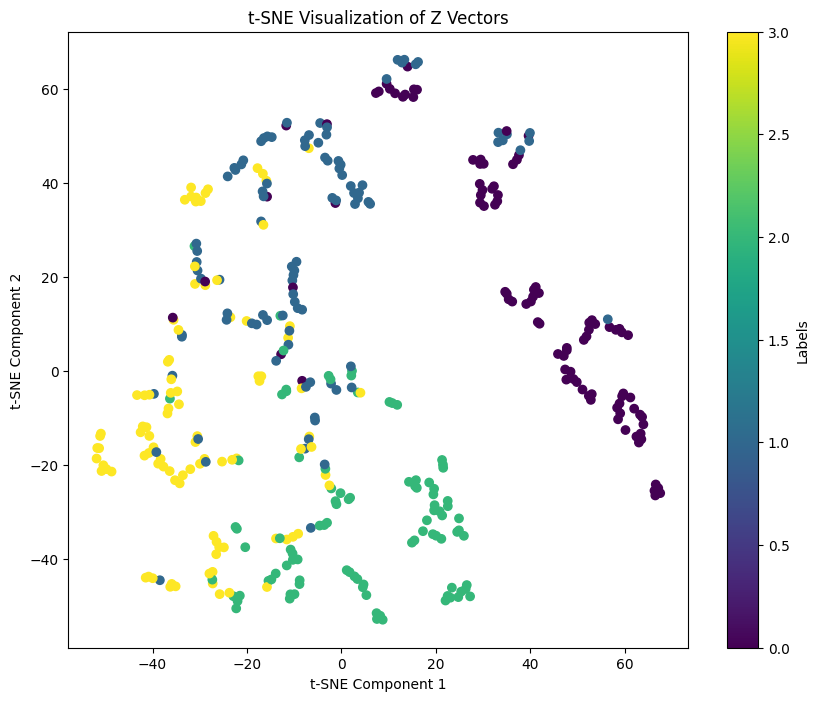

In [ ]:
# prompt: visualize the z vectors in the_zs using t-sne with the labels in the_labels as color code

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'the_zs' and 'the_labels' are defined from the previous code execution
zs = np.concatenate(the_zs, axis=0)
labels = np.concatenate(the_labels, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
z_embedded = tsne.fit_transform(zs)

# Visualize
plt.figure(figsize=(10, 8))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=labels, cmap='viridis')  # Use 'viridis' or any other suitable colormap
plt.colorbar(label='Labels') ## jz: there must be better legend possible, but this will do for now
plt.title('t-SNE Visualization of Z Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


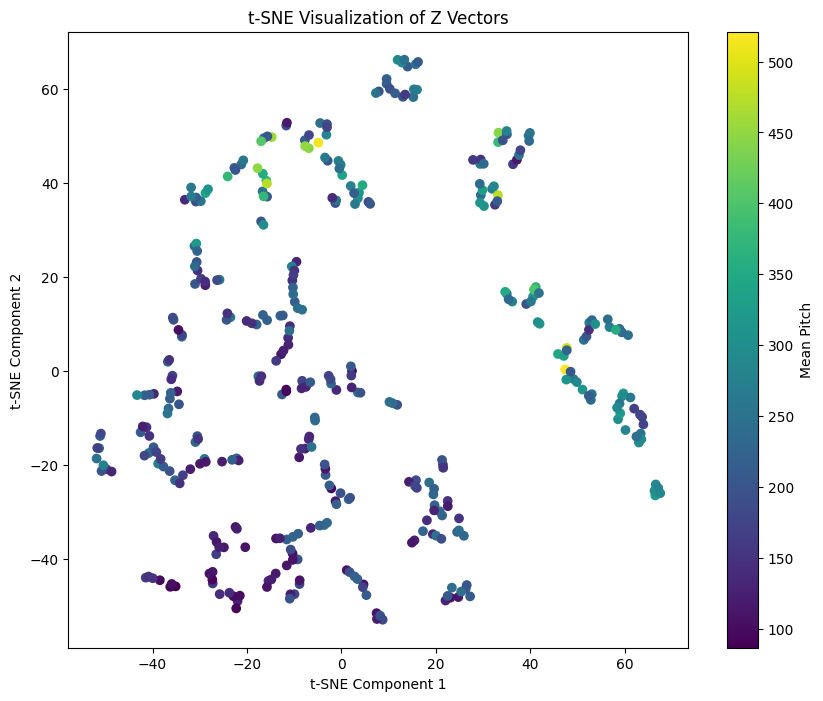

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'the_zs' and 'the_labels' are defined from the previous code execution
#zs = np.concatenate(the_zs, axis=0)
mean_pitches = np.concatenate(the_mean_pitches, axis=0)

# Apply t-SNE
#tsne = TSNE(n_components=2, random_state=0, perplexity=5)
#z_embedded = tsne.fit_transform(zs)

# Visualize
plt.figure(figsize=(10, 8))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=mean_pitches, cmap='viridis')  # Use 'viridis' or any other suitable colormap
plt.colorbar(label='Mean Pitch') ## jz: there must be better legend possible, but this will do for now
plt.title('t-SNE Visualization of Z Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
